# NVIDIA Embedding NIMs

Use `langchain-nvidia-ai-endpoints` to connect your LangChain applications to NVIDIA embedding models. You can access these models through the NVIDIA API Catalog for testing and prototyping, or deploy them on your own infrastructure using NVIDIA NIM microservices.

In this notebook, you will:
- Generate embeddings for similarity search and retrieval tasks
- Handle long text inputs with automatic truncation
- Build a retrieval-augmented generation (RAG) application
- Connect to self-hosted embedding models

For chat models and reranking, refer to [ChatNVIDIA](https://python.langchain.com/docs/integrations/chat/nvidia_ai_endpoints/) and [NVIDIARerank](https://python.langchain.com/api_reference/nvidia_ai_endpoints/reranking/langchain_nvidia_ai_endpoints.reranking.NVIDIARerank.html).

## Installation

In [17]:
%pip install --upgrade --quiet  langchain-nvidia-ai-endpoints


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setup

**To get started:**

1. Create a free account with [NVIDIA](https://build.nvidia.com/), which hosts NVIDIA AI Foundation models.

2. Select the `Retrieval` tab, then select your model of choice.

3. Under `Input` select the `Python` tab, and click `Get API Key`. Then click `Generate Key`.

4. Copy and save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [18]:
import os

# Set your API key directly here
os.environ["NVIDIA_API_KEY"] = "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"
print("API key set successfully")

API key set successfully


Use the `NVIDIAEmbeddings` class to connect to NVIDIA embedding models for retrieval-augmented generation (RAG) and semantic search.

## Working with NIMs on the NVIDIA API Catalog

Specify a model when you create the `NVIDIAEmbeddings` instance, or use the default model.

In [22]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")

The `NVIDIAEmbeddings` class provides standard embedding methods:

- `embed_query`: Generate an embedding for a single query
- `embed_documents`: Generate embeddings for multiple documents
- `aembed_query` / `aembed_documents`: Async versions of the above

## Test Embedding Similarity

Compare embeddings to measure semantic similarity between queries and documents. In this example, you'll see how well different query-document pairs match.

### Generate Query Embeddings

In [23]:
print("\nSequential Embedding: ")
q_embeddings = [
    embedder.embed_query("What's the weather like in Komchatka?"),
    embedder.embed_query("What kinds of food is Italy known for?"),
    embedder.embed_query("What's my name? I bet you don't remember..."),
    embedder.embed_query("What's the point of life anyways?"),
    embedder.embed_query("The point of life is to have fun :D"),
]
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Sequential Embedding: 
Shape: (5, 1024)


### Generate Document Embeddings

In [24]:
print("\nBatch Document Embedding: ")
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Batch Document Embedding: 
Shape: (5, 1024)


Compare the query and document embeddings to see which documents match each query:

In [25]:
%pip install --upgrade --quiet  matplotlib scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


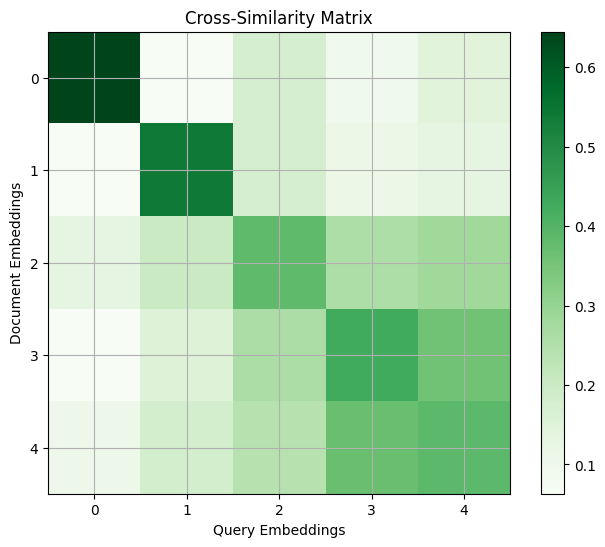

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix between q_embeddings and d_embeddings
cross_similarity_matrix = cosine_similarity(
    np.array(q_embeddings),
    np.array(d_embeddings),
)

# Plotting the cross-similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")
plt.colorbar()
plt.title("Cross-Similarity Matrix")
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.grid(True)
plt.show()

As a reminder, the queries and documents sent to our system were:

**Queries:**

- What's the weather like in Komchatka?

- What kinds of food is Italy known for?

- What's my name? I bet you don't remember...

- What's the point of life anyways?

- The point of life is to have fun :D

**Documents:**

- Komchatka's weather is cold, with long, severe winters.

- Italy is famous for pasta, pizza, gelato, and espresso.

- I can't recall personal names, only provide information.

- Life's purpose varies, often seen as personal fulfillment.

- Enjoying life's moments is indeed a wonderful approach.

## Handle Long Text with Truncation

Embedding models have a maximum input length. When your text exceeds this limit, you can use the `truncate` parameter to automatically trim the input.

The `truncate` parameter accepts three options:
- `"NONE"` (default): Raise an error if the input exceeds the limit
- `"START"`: Remove tokens from the beginning of the text
- `"END"`: Remove tokens from the end of the text

In [27]:
long_text = "AI is amazing, amazing is " * 100

In [28]:
strict_embedder = NVIDIAEmbeddings()
try:
    strict_embedder.embed_query(long_text)
except Exception as e:
    print("Error:", e)

Error: [###] Input length 640 exceeds maximum allowed token size 512
{'error': 'Input length 640 exceeds maximum allowed token size 512'}


In [29]:
truncating_embedder = NVIDIAEmbeddings(truncate="END")
truncating_embedder.embed_query(long_text)[:5]

[-0.017608642578125,
 -0.00856781005859375,
 -0.042510986328125,
 0.039764404296875,
 -0.0012359619140625]

## Build a RAG Application

Combine NVIDIA embeddings with a vector store and chat model to build a retrieval-augmented generation application. This example uses FAISS for vector storage and Mixtral for generation.

In [30]:
%pip install --upgrade --quiet  langchain faiss-cpu tiktoken langchain_community

from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_nvidia_ai_endpoints import ChatNVIDIA


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"],
    embedding=NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5"),
)
retriever = vectorstore.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

model = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("where did harrison work?")

'Based on the document provided, Harrison worked at Kensho.'

In [ ]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer using information solely based on the following context:\n<Documents>\n{context}\n</Documents>"
            "\nSpeak only in the following language: {language}",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "where did harrison work", "language": "italian"})

## Working with Self-Hosted NVIDIA NIMs

All the examples above can also be run using self-hosted NVIDIA NIMs. When ready to deploy, you can self-host embedding models with NVIDIA NIM—which is included with the NVIDIA AI Enterprise software license—and run them anywhere, giving you ownership of your customizations and full control of your intellectual property (IP) and AI applications.

To use a self-hosted NIM instead of the NVIDIA API Catalog, simply specify the `base_url` parameter when creating the `NVIDIAEmbeddings` instance, as shown in the examples below. After this configuration, all the embedding operations (similarity search, truncation, RAG) demonstrated earlier will work the same way.

[Learn more about NIMs](https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/)


In [ ]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

# connect to an embedding NIM running at localhost:8080, specifying a specific model
embedder = NVIDIAEmbeddings(base_url="http://localhost:8080/v1", model="nvidia/nv-embedqa-e5-v5")


In [ ]:
# connect to a default embedding NIM running at localhost:8080
embedder = NVIDIAEmbeddings(base_url="http://localhost:8080/v1")
